# Project 1: Digit Classification with KNN and Naive Bayes

**Brad Andersen**

**MIDS W207**

**June 10, 2019**

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [0]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [0]:
# Load the digit data from https://www.openml.org/d/554 or from default local location '~/scikit_learn_data/...'
X, Y = fetch_openml(name='mnist_784', return_X_y=True, cache=False)


# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print 'data shape: ', X.shape
print 'label shape:', Y.shape

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


## Question 1

(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

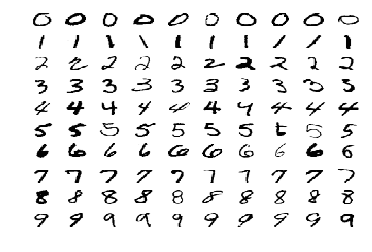

In [0]:
def get_example_digit_indices(digit_list, num_examples = 10):
    """
    Retrieves randomly-selected indices within MNIST data identifying digits 0 through 9.

    Indices are returned as a list of lists: the former list of length 10, one list per digit in
    zero-indexed numeric order; the latter lists being indices within specified MNIST data 
    classified as a digit associated with the list (e.g. indices of 0s in one list, indices
    of 1s in the next, etc.)

    Arguments
    ---------
    digit_list: list
    
    List of numbers whose values identify digit classifications (e.g. '3', '5') and
    whose indices map to the digit's data within the MNIST image data (required)

    num_examples: int
    
    Number of examples of each digit to identify and whose indices to retrieve
    (default: 10)

    Returns
    -------
    List of lists.  Specifically, 10 lists (one for each digit 0 through 9) of indices within 
    MNIST digit image data.  Each index is associated with image data for a digit of the
    associated classification (i.e. the first list contains a list of indices identifying images
    classified as 0s, the second list contains a list of indices identifying images classified as
    1s, etc.)
    """

    assert (type(digit_list) is np.ndarray), "digit_list must be of type NumPy ndarray"
    assert (digit_list.size > 0), "digit_list must not be empty"
    assert (type(num_examples) is int), "num_examples must be of type int"
    assert (0 < num_examples & num_examples <= 20), "num_examples must be an int between 1 and 10"

    # Create the list of lists to populate with image indices
    digit_indices = [[] for i in range(10)]

    # How many lists we have filled with the requisite number of digit indices
    complete_index_lists = 0

    # Randomly select an index from which to be sourcing image data.  Because we iterate through
    # the data and loop to the beginning should we reach the end of the data without completing 
    # all 10 lists, also identify the index at which to stop.
    current_digit_list_idx = np.random.randint(1, digit_list.size)
    final_digit_list_idx = current_digit_list_idx - 1

    # Iterate through the digit data, exiting only if we've filled all 10 lists with the requisite
    # number of digit indices, or if we've sourced/examined all digit data
    while (complete_index_lists < 10 and current_digit_list_idx != final_digit_list_idx):

        # Get the element, ensuring it is a string representing a single digit (e.g. '3', '5')
        example_digit = digit_list[current_digit_list_idx]
        if (type(example_digit) is str and example_digit.isdigit() and len(example_digit) == 1):

            # Convert digit string to integer value
            example_digit = int(example_digit)
            
            # If the list of indices associated with this digit is not filled to the requisite
            # number, append it to the list
            if (len(digit_indices[example_digit]) < num_examples):
                digit_indices[example_digit].append(current_digit_list_idx)

                # If the list of indices is now filled, increment the number of completed lists
                if (len(digit_indices[example_digit]) == num_examples):
                    complete_index_lists += 1

        # Move to the next element in the digit data
        current_digit_list_idx += 1
        if (current_digit_list_idx == digit_list.size):
            current_digit_list_idx = 0

    return digit_indices

def P1(num_examples = 10):
    """
    Creates a 10 x 10 grid to visualize 10 MNIST examples of each digit.
    
    Arguments
    ---------
    num_examples: int
    
    Number of examples of each digit to identify and whose indices to retrieve
    (default: 10)
    """

    assert (type(num_examples) is int), "num_examples must be of type int"
    assert (0 < num_examples & num_examples <= 10), "num_examples must be an int between 1 and 10"
    
    # Retrieve the lists of indices identifying digits' image data within the MNIST data
    digit_indices = get_example_digit_indices(Y, num_examples)

    # Create the 10 x 10 grid of axes (i.e. subplots for each digit image)
    fig, ax = plt.subplots(nrows = 10, ncols = num_examples)

    # Iterate through the list of lists, rendering each digit image associated with the current
    # index.  An assumption is made that each image is represented using 784 values (a matrix of
    # 28 x 28) between 0 and 1, inclusive.
    for i in range(0, 10):
        for j in range(0, num_examples):
            ax[i][j].axis("off")
            ax[i][j].imshow(
                X = np.reshape(X[digit_indices[i][j]], (28, 28)),
                aspect = "auto",
                cmap = plt.get_cmap("Greys")
            )

    plt.show()

P1(10)

## Question 2

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

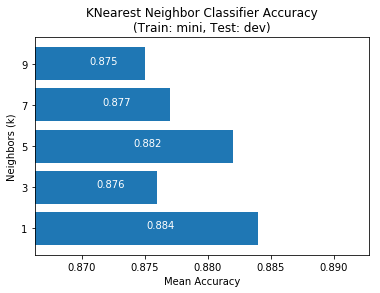

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       106
           1       0.89      0.98      0.93       118
           2       0.90      0.79      0.84       106
           3       0.93      0.87      0.90        97
           4       0.91      0.85      0.88        92
           5       0.86      0.88      0.87        88
           6       0.92      0.92      0.92       102
           7       0.85      0.94      0.89       102
           8       0.83      0.77      0.80        94
           9       0.80      0.86      0.83        95

   micro avg       0.88      0.88      0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.89      0.88      0.88      1000



In [0]:
def P2(k_values):
    """
    Evaluates KNearestNeighbor classifier accuracy using models trained on "mini" data set.

    Arguments
    ---------
    k_values: list

    List of k values with which to create and evaluate KNearestNeighbor classifiers
    """

    assert (type(k_values) is list), "k_values must be of type list"
    assert (len(k_values) > 0), "k_values list must not be empty"

    # Iterate over the list of k values, creating and evaluating the accuracy of 
    # K-nearest-neighbor classifiers for each value of k
    k_list = list()
    accuracy_list = list()
    k1_predicted = None
    for k in k_values:
        classifier = KNeighborsClassifier(n_neighbors = k)
        classifier.fit(X = mini_train_data, y = mini_train_labels)
        k_list.append(str(k))
        accuracy_list.append(classifier.score(X = dev_data, y = dev_labels))
        if (k == 1):
            k1_predicted = classifier.predict(X = dev_data)

    # Plot the data using a horizontal histogram
    fig, ax = plt.subplots()
    xlim_minimum = min(accuracy_list) * 0.99
    ax.set(
        xlim = [xlim_minimum, max(accuracy_list) * 1.01],
        title = "KNearest Neighbor Classifier Accuracy\n(Train: mini, Test: dev)",
        xlabel = "Mean Accuracy",
        ylabel = "Neighbors (k)"
    )
    for i, accuracy in enumerate(accuracy_list):
        ax.text(xlim_minimum + (accuracy - xlim_minimum) / 2, y = i, s = accuracy, color = "white")
    ax.barh(k_list, accuracy_list)
    plt.show()

    # Print the classification report showing the performance of the k=1 classifier for each digit
    # represented in the development data set    
    print(classification_report(dev_labels, k1_predicted))

k_values = [1, 3, 5, 7, 9]
P2(k_values)

### Answer

Two digits stand out in the *k*=1 classifier's classification report:

*   **8** - Digit "8" has the lowest *recall* value among the ten digits; i.e. the lowest ratio of correctly-identified digits to the number of relevant values that should have been returned.
*   **9** - Digit "9" has the lowest *precision* value among the ten digits; i.e. the lowest ratio of correctly-identified digits to the total number of values that should have been returned.

However, if "difficulty" is defined as the lowest mean value among digits -- (*precision* + *recall*) / 2 -- in other words the *f1 score* -- digit 8 has the lowest f1 score.




## Question 3

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

### Answer

See histograms below the code cell.

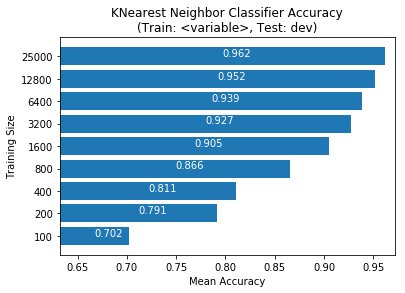

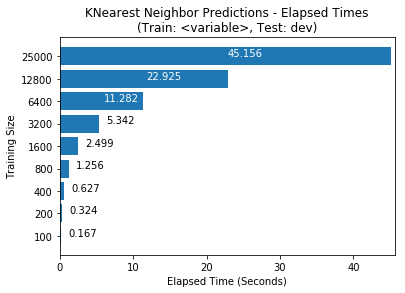

In [0]:
def calculate_training_accuracy(train_size, k = 1):
    """
    Calculates the accuracy of a KNearestNeighbor classifier using a specified training data set 
    size and nearest neighbor count.
    
    This method relies upon values defined in the notebook's initial code cells, where data is
    loaded from the MNIST data set, and divided into initial training and test data sets.
    
    
    Arguments
    ---------
    
    train_size: int
    
    Size of training set with which to train the classifier
    
    classifier: object
    
    Method parameter in which the KNearestNeighbor classifier will be returned
    
    k: int 
    
    Nearest neighbor count with which to define the classifier (default: 1)
    
    Return
    ------
    
    Two-item tuple containing the KNearestNeighbor classifier and its calculated accuracy using 
    test data identified in the notebook's initial cells.
    """
    
    assert (type(train_size) is int), "train_size must be of type int"
    assert (type(k) is int), "k must be of type int"
    assert (k > 0), "k must be greater than 0"
    
    # Identify the training data set
    cur_train_data, cur_train_labels = X[:train_size], Y[:train_size]

    # Create and train/fit the KNearestNeighbor classifier
    classifier = KNeighborsClassifier(n_neighbors = k)
    classifier.fit(X = cur_train_data, y = cur_train_labels)

    # Return the classifier and its calculated accuracy 
    return classifier, classifier.score(X = dev_data, y = dev_labels)

def P3(train_sizes, accuracies):
    """
    Trains, evaluates accuracy, and performs MNIST data predictions using specified training set
    sizes.

    A KNearestNeighbor classifier with k = 1 is used for each training set size.

    Arguments
    ---------
    train_sizes: list

    Integer list of sizes of various training data sets with which to train that classifier

    accuracies: list

    List with no elements.  P3 returns classifier accuracy and elapsed time for predictions in the
    form of a two-element tuple -- one tuple per training set size evaluated.  Elements of each
    tuple are classifier accuracy and elapsed time of prediction in seconds.
    """

    assert (type(train_sizes) is list), "train_sizes must be of type list"
    assert (len(train_sizes) > 0), "train_sizes must not be empty"
    assert (all(isinstance(train_size, int) for train_size in train_sizes)), "train_sizes list must contain only integers"
    assert (type(accuracies) is list), "accuracies must be of type list"
    assert (len(accuracies) == 0), "accuracies must be empty"

    # Iterate through the list of training data sizes, building and evaluating KNearestNeighbor
    # classifiers of the specified sizes
    for train_size in train_sizes:

        # Create the classifier and evaluate its accuracy
        classifier, accuracy = calculate_training_accuracy(train_size)

        # Perform predictions using test data, and calculate each prediction's elapsed time
        time_begin = time.time()
        classifier.predict(X = dev_data)
        seconds_elapsed = time.time() - time_begin

        # Append the accuracy-elapsed time tuple to the specified "accuracies" list
        accuracies.append((accuracy, seconds_elapsed))

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []
P3(train_sizes, accuracies)

# Create lists from each tuple returned by P3
accuracy_list = [accuracy[0] for accuracy in accuracies]
elapsed_time_list = [round(accuracy[1], 3) for accuracy in accuracies]

# Create and render the horizontal histogram for classifier accuracies
fig, ax = plt.subplots()
xlim_minimum = min(accuracy_list) * 0.9
ax.set(
    xlim = [xlim_minimum, max(accuracy_list) * 1.01],
    title = "KNearest Neighbor Classifier Accuracy\n(Train: <variable>, Test: dev)",
    xlabel = "Mean Accuracy",
    ylabel = "Training Size"
)
for i, accuracy in enumerate(accuracy_list):
    ax.text(xlim_minimum + (accuracy - xlim_minimum) / 2, y = i, s = accuracy, color = "white")
ax.barh([str(train_size) for train_size in train_sizes], accuracy_list)
plt.show()

# Create and render the horizontal histogram for classifiers' prediction's elapsed times
fig, ax = plt.subplots()
ax.set(
    xlim = [0, max(elapsed_time_list) * 1.01],
    title = "KNearest Neighbor Predictions - Elapsed Times\n(Train: <variable>, Test: dev)",
    xlabel = "Elapsed Time (Seconds)",
    ylabel = "Training Size"
)
for i, elapsed_time in enumerate(elapsed_time_list):
    if (elapsed_time < 10):
        ax.text(elapsed_time + 1, y = i, s = elapsed_time)
    else:
        ax.text(
            xlim_minimum + (elapsed_time - xlim_minimum) / 2, 
            y = i, 
            s = elapsed_time,
            color = "white"
        )
ax.barh([str(train_size) for train_size in train_sizes], elapsed_time_list)
plt.show()


## Question 4

(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

### Out Of Band Classifier Analysys

To better understand the growth of the accuracy of a KNearest Neighbor classifier, I trained classifiers using the MNIST dataset, different sizes of training data (in increments of 100), and two values for *k* (1 and 2).  Training set size, classifier accuracy, and the time to score the accuracy were recorded in two comma-separated lists (see  *k1_data.csv* and *k2_data.csv* beneath the *data* directory).

Note that the actual values recorded for n = 60000 in both data sets were as follows:

| k | Training Size | Accuracy | Elapsed Time |
| - | ------------- | -------- | ------------ |
| 1 | 60,000 | 0.971 | 46.8913 |
| 2 | 60,000 | 0.970 | 46.9841 |

Accuracy values will be used for comparison later when examining the linear regression model trained on the same data.

Plotting the growth of classifier accuracy with this data revealed the following:

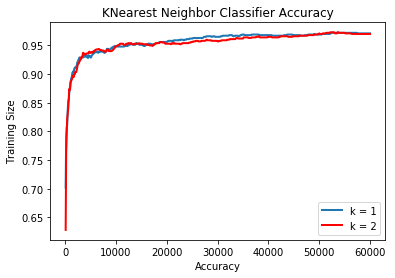

In [0]:
# Retrieve CSV data from classifier accuracy files
k1_data_url = "https://raw.githubusercontent.com/bdandersen-berkeley/mids/master/W207/homework/data/k1_data.csv"
k2_data_url = "https://raw.githubusercontent.com/bdandersen-berkeley/mids/master/W207/homework/data/k2_data.csv"
k1_accuracy_data = np.loadtxt(k1_data_url, delimiter = ",", skiprows = 1)
k2_accuracy_data = np.loadtxt(k2_data_url, delimiter = ",", skiprows = 1)

assert (k1_accuracy_data.shape == (600, 3))
assert (k2_accuracy_data.shape == (600, 3))

# Plot the data
fig, ax = plt.subplots()
ax.set(
    title = "KNearest Neighbor Classifier Accuracy",
    xlabel = "Accuracy",
    ylabel = "Training Size"
)
plt.plot(np.array(k1_accuracy_data[:, 0]), np.array(k1_accuracy_data[:, 1]), label = 'k = 1', linewidth = 2)
plt.plot(np.array(k2_accuracy_data[:, 0]), np.array(k2_accuracy_data[:, 1]), "red", label = 'k = 2', linewidth = 2)
ax.legend()
plt.show()

np.random.seed(0)
k1_shuffle = np.random.permutation(np.arange(k1_accuracy_data.shape[0]))
k2_shuffle = np.random.permutation(np.arange(k2_accuracy_data.shape[0]))


Clearly, accuracy growth is not linear.  Instead, it resembles a reciprocal function.

I next trained a linear regression model on a randomized sample of data retrieved from *k1_data.csv*, and used it to predict the accuracy of a KNearest Neighbor classifier trained with 60,000 elements:

Training set size: 480 , Test set size: 118
Predicted classifier accuracy on training size of 60,000: [0.98454743]


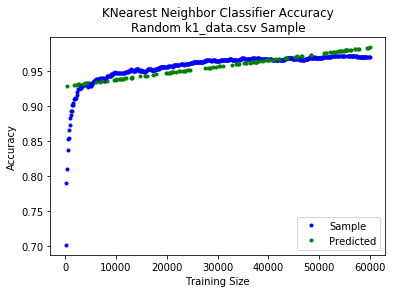

In [0]:
shuffle = np.random.permutation(np.arange(k1_accuracy_data.shape[0]))
X, y = [k1_accuracy_data[row][0] for row in shuffle], [k1_accuracy_data[row][1] for row in shuffle]

training_max_idx = int(np.trunc(k1_accuracy_data.shape[0] * 0.8))
testing_max_idx = k1_accuracy_data.shape[0] - 1

x_train_data = list()
for i, elem in enumerate(X[:training_max_idx]):
  x_train_data.append([elem])
x_test_data = list()
for i, elem in enumerate(X[training_max_idx + 1:testing_max_idx]):
  x_test_data.append([elem])
y_train_data = list()
for i, elem in enumerate(y[:training_max_idx]):
  y_train_data.append([elem])
y_test_data = list()
for i, elem in enumerate(y[training_max_idx + 1:testing_max_idx]):
  y_test_data.append([elem])
print "Training set size:", len(x_train_data), ", Test set size:", len(x_test_data)
  
regression = LinearRegression().fit(np.array(x_train_data), np.array(y_train_data))
y_predicted_data = regression.predict(x_test_data)
predicted_n_60000 = regression.predict([[60000]])
print "Predicted classifier accuracy on training size of 60,000:", predicted_n_60000[0]

# Plot the data
fig, ax = plt.subplots()
ax.set(
    title = "KNearest Neighbor Classifier Accuracy\nRandom k1_data.csv Sample",
    ylabel = "Accuracy",
    xlabel = "Training Size"
)
plt.plot(np.array(x_train_data), np.array(y_train_data), "b.", label = "Sample")
plt.plot(np.array(x_test_data), np.array(y_predicted_data), "g.", label = "Predicted")
ax.legend()
plt.show()

If the regression model was accurate, plotting test values versus predicted values should result in a line that is generally straight, and along a line drawn at 45 degrees from the plot's origin.  This is not the case:


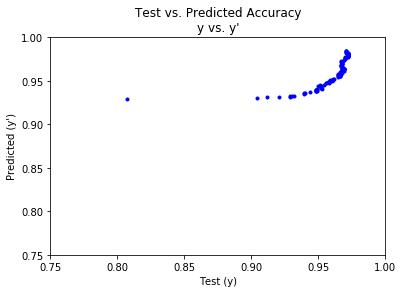

In [0]:
fig, ax = plt.subplots()
ax.set(
    title = "Test vs. Predicted Accuracy\ny vs. y'",
    xlabel = "Test (y)",
    ylabel = "Predicted (y')"
)
ax.set_xlim(0.75, 1.0)
ax.set_ylim(0.75, 1.0)
plt.plot(np.array(y_test_data), np.array(y_predicted_data), "b.")
plt.show()

### Achieving Linearity with Data Transformation

Given the reciprocal nature of the KNearest Neighbor accuracy distribution, we can transform values as follows to achieve linearity in the regression:

Predicted classifier accuracy on training size of 60,000: [0.96079219]


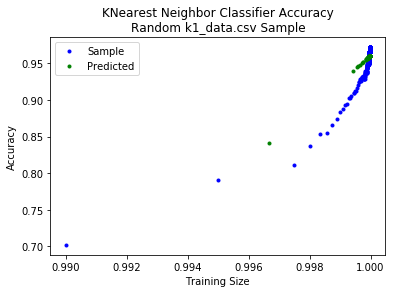

(0.9895008333333333, 1.0004825)


In [0]:
x_train_data_transformed = list()
for i, elem in enumerate(X[:training_max_idx]):
  x_train_data_transformed.append([1 - 1 / elem])
x_test_data_transformed = list()
for i, elem in enumerate(X[training_max_idx + 1:testing_max_idx]):
  x_test_data_transformed.append([1 - 1 / elem])
  
regression = LinearRegression().fit(np.array(x_train_data_transformed), np.array(y_train_data))
y_predicted_data = regression.predict(x_test_data_transformed)
predicted_n_60000 = regression.predict([[1 - 1 / 60000]])
print "Predicted classifier accuracy on training size of 60,000:", predicted_n_60000[0]

# Plot the data
fig, ax = plt.subplots()
ax.set(
    title = "KNearest Neighbor Classifier Accuracy\nRandom k1_data.csv Sample",
    ylabel = "Accuracy",
    xlabel = "Training Size"
)
plt.plot(np.array(x_train_data_transformed), np.array(y_train_data), "b.", label = "Sample")
plt.plot(np.array(x_test_data_transformed), np.array(y_predicted_data), "g.", label = "Predicted")
ax.legend()
plt.show()

print ax.get_xlim()

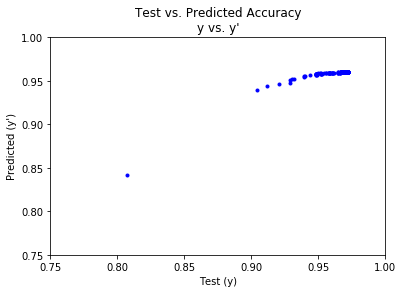

In [0]:
fig, ax = plt.subplots()
ax.set(
    title = "Test vs. Predicted Accuracy\ny vs. y'",
    xlabel = "Test (y)",
    ylabel = "Predicted (y')"
)
ax.set_xlim(0.75, 1.0)
ax.set_ylim(0.75, 1.0)
plt.plot(np.array(y_test_data), np.array(y_predicted_data), "b.")
plt.show()

## Question 5

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

### Answer

See matrices below the code cell.

Classifier accuracy:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       106
           1       0.97      0.99      0.98       118
           2       0.97      0.96      0.97       106
           3       0.96      0.95      0.95        97
           4       0.98      1.00      0.99        92
           5       0.97      0.94      0.95        88
           6       0.97      0.98      0.98       102
           7       0.97      0.99      0.98       102
           8       0.96      0.90      0.93        94
           9       0.99      0.99      0.99        95

   micro avg       0.97      0.97      0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000

Confusion matrix:
[[105   1   0   0   0   0   0   0   0   0]
 [  0 117   0   0   0   0   0   0   1   0]
 [  1   0 102   0   0   0   0   2   1   0]
 [  0   1   0  92   0   2   0   1   1   0]
 [  0   0   0   0  92   0   0 

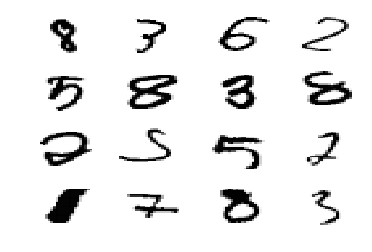

In [0]:
def P5():
  """
  """

  # Create and train/fit the KNearestNeighbor classifier using k = 1
  classifier = KNeighborsClassifier(n_neighbors = 1)
  classifier.fit(X = train_data, y = train_labels)
  predicted = classifier.predict(X = dev_data)

  # Create the confusion matrix, comparing development data to that predicted by the
  # classifier
  confusion_mx = confusion_matrix(
    dev_labels, 
    predicted,
    labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
  )

  print("Classifier accuracy:")
  print(classification_report(dev_labels, predicted))
  print("Confusion matrix:")
  print(confusion_mx)
  
  # Iterate through the development data comparing true labels to those predicted by
  # the classifier.  Maintain the index of those whose prediction was incorrect.
  incorrect_image_indices = list()
  for i in range(len(dev_labels)):
    if (dev_labels[i] != predicted[i]):
      incorrect_image_indices.append(i)
      
  # Render example digit images that were predicted incorrectly
  assert (len(incorrect_image_indices) >= 9), "Fewer than 9 incorrect predictions"
  figure_dim = 4 if len(incorrect_image_indices) >= 16 else 3
  
  image_index = 0
  fig, ax = plt.subplots(figure_dim, figure_dim)
  for i in range(0, figure_dim):
    for j in range(0, figure_dim):
      ax[i][j].axis("off")
      ax[i][j].imshow(
        X = np.reshape(dev_data[incorrect_image_indices[image_index]], (28, 28)),
        aspect = "auto",
        cmap = plt.get_cmap("Greys")
      )
      image_index += 1
    
  print("Examples of incorrectly-predicted digits:")
  plt.show()
  
P5()


## Question 6

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

*   List item
*   List item



Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

In [0]:
def get_valid_neighbor_coordinates(pixel, dimension = (28, 28)):
    """
    Retrieves a list of coordinates adjacent to the specified pixel.
    
    Arguments
    ---------
    
    pixel: tuple with ints as values 
    
    Coordinates of the pixel whose valid neighbor coordinates to return (required)
    
    dimension: tuple with ints as values 
    
    Dimensions of the matrix in which the pixel's coordinates apply (default: (28, 28))
    
    Return
    ------
    List of tuples representing the coordinates of valid neighbor pixels surrounding the specified
    pixel
    
    """
    
    assert (type(pixel) == tuple), "pixel must be of type tuple"
    assert (type(pixel[0]) == int and type(pixel[1]) == int), "pixel coordinates must be integers"
    assert (pixel[0] >= 0 and pixel[1] >= 0), "pixel coordinates must be greater than 0"
    
    assert (type(dimension) == tuple), "dimension must be of type tuple"
    assert (type(dimension[0]) == int and type(dimension[1]) == int), "dimension coordinates must be integers"
    assert (dimension[0] >= 0 and dimension[1] >= 0), "dimension coordinates must be greater than 0"
    
    assert (pixel[0] < dimension[0] and pixel[1] < dimension[1]), "pixel coordinates must be within dimension bounds"

    # Calculate the potentially-invalid pixel coordinate values of neighbor pixels
    col_neighbors = [pixel[0] - 1, pixel[0], pixel[0] + 1]
    row_neighbors = [pixel[1] - 1, pixel[1], pixel[1] + 1]
    
    # Remove column values outside the bounds of the specified dimensions
    if (col_neighbors[2] > dimension[0] - 1):
        del col_neighbors[2]
    if (col_neighbors[0] < 0):
        del col_neighbors[0]
        
    # Remove row values outside the bounds of the specified dimensions
    if (row_neighbors[2] > dimension[1] - 1):
        del row_neighbors[2]
    if (row_neighbors[0] < 0):
        del row_neighbors[0]
    
    # Build and return the list of valid neighbor pixel coordinates (including the coordinates of
    # the pixel whose neighbors we're identifying)
    neighbors = list()
    for row in row_neighbors:
        for col in col_neighbors:
            neighbors.append((col, row))
            
    return neighbors

def blur(image, dimension = (28, 28)):
    """
    Blur an image by calculating a weighted average using each pixel's immediate neighbor pixels
    
    Arguments
    ---------
    
    image: ndarray
    
    Array of normalized values representing pixel depths/intensities (i.e. the image we're to
    blur) (required)
    
    dimension: tuple with ints as values 
    
    Dimensions of the matrix with which to identify pixel coordinates when blurring the image
    (default: (28, 28))
    
    Return
    ------
    
    Blurred image.  The image is an array of pixel values, the same dimensions as those specified.
    
    """

    assert (type(image) == np.ndarray), "image must be of type np.ndarray"

    assert (type(dimension) == tuple), "dimension must be of type tuple"
    assert (type(dimension[0]) == int and type(dimension[1]) == int), "dimension coordinates must be integers"
    assert (dimension[0] >= 0 and dimension[1] >= 0), "dimension coordinates must be greater than 0"

    # Reshape the original image into a matrix with the specified dimensions
    image = np.reshape(image, dimension)

    # Create and initialize (with zeros) a matrix of the specified dimensions in which to create
    # the blurred image
    blurred_image = [[0.0 for i in range(dimension[0])] for j in range(dimension[1])]

    # Walk the pixels in the reshaped original image
    for i in range(dimension[0]):
        for j in range(dimension[1]):

            # Retrieve a list of tuples representing the coordinates of the pixels neighboring the
            # current pixel.  Only valid coordinates (i.e. those within the image's dimensions)
            # will be returned.
            neighbors = get_valid_neighbor_coordinates((i, j))

            # Sum the values of the neighboring pixels, then divide by the number of valid
            # neighbors, thereby creating a weighted average value for the current pixel
            sum_of_neighbors = 0.0
            for neighbor in neighbors:
                sum_of_neighbors += image[neighbor[0]][neighbor[1]]
            blurred_image[i][j] = sum_of_neighbors / len(neighbors)

    # Return the blurred image
    return blurred_image

### Blur Test

The following are a sampling of MNIST images and their blurred counterparts to demonstrate that the blurring mechanism is working as expected:

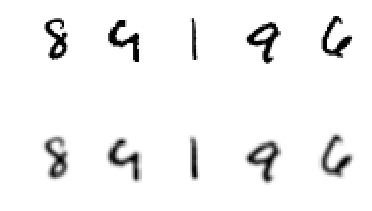

In [0]:
BLURRED_IMAGE_COUNT = 5
fix, ax = plt.subplots(2, BLURRED_IMAGE_COUNT)
for i in range(BLURRED_IMAGE_COUNT):
    ax[0][i].axis("off")
    ax[0][i].imshow(
        np.reshape(dev_data[i], (28, 28)),
        cmap = plt.get_cmap("Greys")
    )
    ax[1][i].axis("off")
    ax[1][i].imshow(
        blur(dev_data[i]),
        cmap = plt.get_cmap("Greys")
    )
plt.show()

### Blurring Test and Development Data

Blur test and development image data for use when training and testing the KNearest Neighbor classifier.  Output images from within the blurred data to help understand that the blurring was successful.

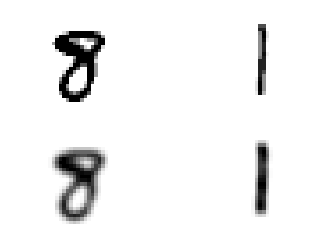

In [0]:
# Walk the development and training data, and create lists of blurred representations of
# the associated images
blurred_dev_data = list()
blurred_train_data = list()

for image in dev_data:
    blurred_dev_data.append(blur(image))
for image in train_data:
    blurred_train_data.append(blur(image))

# Render images to ensure that our blurring efforts worked
TEST_IMAGE_INDEX = 51
fix, ax = plt.subplots(2, 2)

ax[0][0].axis("off")
ax[0][0].imshow(
    np.reshape(dev_data[TEST_IMAGE_INDEX], (28, 28)),
    cmap = plt.get_cmap("Greys")
)
ax[1][0].axis("off")
ax[1][0].imshow(
    blurred_dev_data[TEST_IMAGE_INDEX],
    cmap = plt.get_cmap("Greys")
)
ax[0][1].axis("off")
ax[0][1].imshow(
    np.reshape(train_data[TEST_IMAGE_INDEX], (28, 28)),
    cmap = plt.get_cmap("Greys")
)
ax[1][1].axis("off")
ax[1][1].imshow(
    blurred_train_data[TEST_IMAGE_INDEX],
    cmap = plt.get_cmap("Greys")
)
plt.show()

In [0]:
def demonstrate_blurred_immage_classifier_accuracy(train_data, test_data):
    
    classifier = KNeighborsClassifier(n_neighbors = 1)
    classifier.fit(X = train_data, y = train_labels)
    print "Classifier accuracy:", classifier.score(X = test_data, y = dev_labels)
    print classification_report(dev_labels, classifier.predict(X = test_data))

### KNearest Neighbor classifier accuracy (k = 1): **Unprocessed**  training data, **unprocessed** test data

The following classifier, while not required, is trained and tested as a benchmark or point of reference.

In [0]:
demonstrate_blurred_immage_classifier_accuracy(train_data, dev_data)

Classifier accuracy: 0.971
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       106
           1       0.97      0.99      0.98       118
           2       0.97      0.96      0.97       106
           3       0.96      0.95      0.95        97
           4       0.98      1.00      0.99        92
           5       0.97      0.94      0.95        88
           6       0.97      0.98      0.98       102
           7       0.97      0.99      0.98       102
           8       0.96      0.90      0.93        94
           9       0.99      0.99      0.99        95

   micro avg       0.97      0.97      0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



### KNearest Neighbor classifier accuracy: **Blurred** training data, **unprocessed** test data



In [0]:
flattened_blurred_train_data = np.empty(shape = (len(blurred_train_data), 784))
for i in range(len(blurred_train_data)):
    flattened_blurred_train_data[i:] = np.reshape(blurred_train_data[i], (1, 784))
demonstrate_blurred_immage_classifier_accuracy(flattened_blurred_train_data, dev_data)

Classifier accuracy: 0.976
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       106
           1       0.98      0.99      0.99       118
           2       0.97      0.96      0.97       106
           3       0.95      0.98      0.96        97
           4       0.98      1.00      0.99        92
           5       0.99      0.93      0.96        88
           6       0.98      0.99      0.99       102
           7       0.98      0.98      0.98       102
           8       0.96      0.94      0.95        94
           9       0.99      0.99      0.99        95

   micro avg       0.98      0.98      0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



### KNearest Neighbor classifier accuracy: **Unprocessed** training data, **blurred**  test data

In [0]:
flattened_blurred_dev_data = np.empty(shape = (len(blurred_dev_data), 784))
for i in range(len(blurred_dev_data)):
    flattened_blurred_dev_data[i:] = np.reshape(blurred_dev_data[i], (1, 784))
demonstrate_blurred_immage_classifier_accuracy(train_data, flattened_blurred_dev_data)

Classifier accuracy: 0.971
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       106
           1       0.95      0.99      0.97       118
           2       0.98      0.96      0.97       106
           3       0.97      0.96      0.96        97
           4       0.95      1.00      0.97        92
           5       0.97      0.95      0.96        88
           6       0.97      0.96      0.97       102
           7       0.97      0.99      0.98       102
           8       0.98      0.93      0.95        94
           9       0.99      0.97      0.98        95

   micro avg       0.97      0.97      0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



### KNearest Neighbor classifier accuracy: **Blurred** training data, **blurred** test data



In [0]:
demonstrate_blurred_immage_classifier_accuracy(flattened_blurred_train_data, flattened_blurred_dev_data)

Classifier accuracy: 0.977
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       106
           1       0.98      0.99      0.99       118
           2       0.99      0.97      0.98       106
           3       0.95      0.97      0.96        97
           4       0.98      0.98      0.98        92
           5       0.99      0.93      0.96        88
           6       0.98      0.99      0.99       102
           7       0.98      0.98      0.98       102
           8       0.96      0.97      0.96        94
           9       0.97      0.99      0.98        95

   micro avg       0.98      0.98      0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



### Answer

Considering both precision and recall, it appears that the classifiers trained on the blurred image data are slightly more accurate than those trained on the unprocessed image data.

## Question 7

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

### Gaussian Naive Bayes - Unaltered Training Data

In [0]:
gnb_classifier = GaussianNB()
gnb_classifier.fit(X = train_data, y = train_labels)
gnb_predicted_labels = gnb_classifier.predict(dev_data)

gnb_incorrect_count = 0.0
for i in range(len(gnb_predicted_labels)):
    if gnb_predicted_labels[i] != dev_labels[i]:
        gnb_incorrect_count += 1.0
        
print "Images tested:", len(gnb_predicted_labels)
print "Images incorrectly predicted:", int(gnb_incorrect_count)
print "Classifier accuracy:", 1 - gnb_incorrect_count / len(gnb_predicted_labels)

Images tested: 1000
Images incorrectly predicted: 414
Classifier accuracy: 0.586


### Bernoulli Naive Bayes - Bisected Training Data (binarize Directive)

In [0]:
classifier = BernoulliNB(binarize = 0.5)
classifier.fit(X = train_data, y = train_labels)
predicted_labels = classifier.predict(dev_data)

incorrect_count = 0.0
for i in range(len(predicted_labels)):
    if predicted_labels[i] != dev_labels[i]:
        incorrect_count += 1.0
        
print "Images tested:", len(predicted_labels)
print "Images incorrectly predicted:", int(incorrect_count)
print "Classifier accuracy:", 1 - incorrect_count / len(predicted_labels)

Images tested: 1000
Images incorrectly predicted: 173
Classifier accuracy: 0.827


### Bernoulli Naive Bayes - Bisected Training Data (Mapped Function)

In [0]:
BISECTION = 1.0 / 2.0

def bisect(d):
    return 0 if d < BISECTION else 1

bisected_train_data = np.empty(shape = (len(train_data), 784))
for i in range(len(train_data)):
    bisected_train_data[i] = map(bisect, train_data[i])
bisected_dev_data = np.empty(shape = (len(dev_data), 784))
for i in range(len(dev_data)):
    bisected_dev_data[i] = map(bisect, dev_data[i])
    
classifier = BernoulliNB()
classifier.fit(X = bisected_train_data, y = train_labels)
predicted_labels = classifier.predict(bisected_dev_data)

incorrect_count = 0.0
for i in range(len(predicted_labels)):
    if predicted_labels[i] != dev_labels[i]:
        incorrect_count += 1.0
        
print "Images tested:", len(predicted_labels)
print "Images incorrectly predicted:", int(incorrect_count)
print "Classifier accuracy:", 1 - incorrect_count / len(predicted_labels)

print classification_report(dev_labels, classifier.predict(X = dev_data))


Images tested: 1000
Images incorrectly predicted: 173
Classifier accuracy: 0.827
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       106
           1       0.97      0.80      0.87       118
           2       0.82      0.80      0.81       106
           3       0.73      0.76      0.75        97
           4       0.80      0.82      0.81        92
           5       0.86      0.56      0.68        88
           6       0.91      0.92      0.92       102
           7       1.00      0.82      0.90       102
           8       0.55      0.86      0.67        94
           9       0.79      0.81      0.80        95

   micro avg       0.81      0.81      0.81      1000
   macro avg       0.83      0.81      0.81      1000
weighted avg       0.83      0.81      0.82      1000



### Multinomial Naive Bayes - Trisected Training Data (Mapped Function)

In [0]:
FIRST_TRISECTION = 1.0 / 3.0
SECOND_TRISECTION = 2.0 / 3.0

def trisect(d):
    if (d <= FIRST_TRISECTION):
        return 0
    elif (d <= SECOND_TRISECTION):
        return 1
    return 2

trisected_train_data = np.empty(shape = (len(train_data), 784))
for i in range(len(train_data)):
    trisected_train_data[i] = map(trisect, train_data[i])
trisected_dev_data = np.empty(shape = (len(dev_data), 784))
for i in range(len(dev_data)):
    trisected_dev_data[i] = map(trisect, dev_data[i])
    
classifier = MultinomialNB()
classifier.fit(X = trisected_train_data, y = train_labels)
predicted_labels = classifier.predict(trisected_dev_data)

incorrect_count = 0.0
for i in range(len(predicted_labels)):
    if predicted_labels[i] != dev_labels[i]:
        incorrect_count += 1.0
        
print "Images tested:", len(predicted_labels)
print "Images incorrectly predicted:", int(incorrect_count)
print "Classifier accuracy:", 1 - incorrect_count / len(predicted_labels)

Images tested: 1000
Images incorrectly predicted: 176
Classifier accuracy: 0.824


### Answer

The most accurate naive Bayes classifier trained on MNIST image data is the Bernoilli classifier, separating image density into binary values.  Of interest (but not surprisingly), specifying the `binarize` threshold when initializing the classifier performs identically as when training data is divided using a custom mapped function presumably processing the training and testing data in an identical manner.

Separating image density into three values -- 0, 1, and 2 -- and using a multnomial Naive Bayes classifier to predict images resulted in slightly less accuracy.  I suspect that naive Bayes classifiers would gradually decline in accuracy with an increasing variance in image density (i.e. more shades of gray).  My suspicions are based upon the following observations:

* Classifiers would be 100-percent accurate if there was no variance in image density (i.e. each image pixel was of the same value).
* The best performing classifier(s) of those tested were the Bernoulli classifiers using binary image density data.
* The worst performing classifier of those tested was the Gaussian classifier using the unaltered, normalized image data.



## Question 8

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

### Cross Validation of Bernoulli Naive Bayes Classifier

In [0]:
classifier = GridSearchCV(
    BernoulliNB(binarize = 0.5),
    param_grid = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
)
classifier.fit(X = train_data, y = train_labels)
print "Alpha (smoothing) value of best classifier:", classifier.best_estimator_.alpha

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Alpha (smoothing) value of best classifier: 0.0


The best alpha value for the Bernoulli naive Bayes classifier trained on the MNIST training data is 0.0.

The classifier's accuracy on the MNIST test data is as follows:

In [0]:
print classification_report(test_labels, classifier.best_estimator_.predict(X = test_data))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       862
           1       0.87      0.94      0.91      1001
           2       0.88      0.83      0.85       885
           3       0.80      0.82      0.81       949
           4       0.85      0.80      0.83       870
           5       0.80      0.75      0.77       785
           6       0.91      0.90      0.91       906
           7       0.92      0.87      0.89       939
           8       0.76      0.77      0.76       908
           9       0.75      0.83      0.79       895

   micro avg       0.84      0.84      0.84      9000
   macro avg       0.85      0.84      0.84      9000
weighted avg       0.85      0.84      0.84      9000



### Answer

Yes, I would expect an *alpha* value of 0.0 to generate the most accurate Bernoulli naive Bayes classifier.  In Question 7, we noted that the most accurate naive Bayes classifiers when trained against the MNIST training data were those with images where numerals were represented using fewer shades of gray; of those whose accuracies were measured, the Bernoulli classifier performed the best, as images were represented using just two values, 0 and 1.

Increasing a classifier's *alpha* parameter smooths that data.  Smoothing will alter the image data by introducing additional image densities (i.e. shades of gray).  Therefore, it is no surprise that a classifier with an *alpha* value of 0.0 (presumably no smoothing) would perform with the best accuracy.

## Question 9

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

### Gaussian Naive Bayes Redux

Leveraging the Gaussian naive Bayes classifier generated in Question 7 (see "Gaussian Naive Bayes - Unaltered Training Data"), we can again print its accuracy:

In [0]:
print classification_report(gnb_predicted_labels, classifier.predict(X = dev_data))

print "Images tested:", len(gnb_predicted_labels)
print "Images incorrectly predicted:", int(gnb_incorrect_count)
print "Classifier accuracy:", 1 - gnb_incorrect_count / len(gnb_predicted_labels)

              precision    recall  f1-score   support

           0       0.96      0.84      0.90       123
           1       0.82      0.96      0.88       131
           2       0.28      0.78      0.41        27
           3       0.38      0.71      0.49        51
           4       0.30      0.96      0.45        28
           5       0.19      0.86      0.32        14
           6       0.93      0.69      0.79       154
           7       0.44      0.89      0.59        45
           8       0.74      0.32      0.45       208
           9       0.97      0.53      0.68       219

   micro avg       0.65      0.65      0.65      1000
   macro avg       0.60      0.75      0.60      1000
weighted avg       0.79      0.65      0.67      1000

Images tested: 1000
Images incorrectly predicted: 414
Classifier accuracy: 0.586


### Attempt to Increase Accuracy



In [0]:
BISECTION = 1.0 / 2.0

def bisect(d):
    return 0 if d < BISECTION else 1

classifier = GaussianNB(var_smoothing = 0.2)
classifier.fit(X = train_data, y = train_labels)
predicted_labels = classifier.predict(X = dev_data)

print classification_report(dev_labels, predicted_labels)

incorrect_count = 0.0
for i in range(len(predicted_labels)):
    if predicted_labels[i] != dev_labels[i]:
        incorrect_count += 1.0
        
print "Images tested:", len(predicted_labels)
print "Images incorrectly predicted:", int(incorrect_count)
print "Classifier accuracy:", 1 - incorrect_count / len(predicted_labels)

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       106
           1       0.73      0.96      0.83       118
           2       0.88      0.62      0.73       106
           3       0.76      0.74      0.75        97
           4       0.79      0.78      0.79        92
           5       0.94      0.66      0.77        88
           6       0.82      0.91      0.86       102
           7       0.97      0.86      0.91       102
           8       0.65      0.63      0.64        94
           9       0.69      0.87      0.77        95

   micro avg       0.80      0.80      0.80      1000
   macro avg       0.81      0.80      0.80      1000
weighted avg       0.81      0.80      0.80      1000

Images tested: 1000
Images incorrectly predicted: 198
Classifier accuracy: 0.802


### Answer

Adjusting the Laplace smoothing variability upon initializing the Gaussian naive Bayes classifier helped achieve accuracy similar to that achieved with the Bernoulli naive Bayes classifier.

## Question 10

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

### Rendering Binarized Training Data Images

To facilitate a visual comparison between binarized training data and images generated according to probabilities calculated by the Bernoulli naive Bayes model, we'll retrieve and render a random sample of training data.

In [0]:
# Number of images to render per digit (as required by Question 10)
IMAGES_PER_DIGIT = 20

# Reset the seed for random number generation
np.random.seed()

# Manually binarize the training data images.  It's necessary to perform this operation manually
# as opposed to leveraging the "binarize" parameter of the Bernoulli naive Bayes classifier's
# constructor, as we'll leverage the binarized training data throughout these operations.
BISECTION = 1.0 / 2.0
bisected_train_data = np.empty(shape = (len(train_data), 784))
for i in range(len(train_data)):
    for j in range(784):
        if train_data[i][j] < BISECTION: 
            bisected_train_data[i][j] = 0
        else:
            bisected_train_data[i][j] = 1

# Build and fit the Bernoulli naive Bayes classifier with binarized image data
classifier = BernoulliNB()
classifier.fit(X = bisected_train_data, y = train_labels)

# Convert the pixel value probabilities calculated when training the naive Bayes classifier into
# probability values between 0 and 1 (from their logarithmic representation in the model)
pixel_probabilities = np.empty((10, 784))
for i in range(10):
    np.exp(classifier.feature_log_prob_[i], pixel_probabilities[i])

# Retrieve the indices of images in the training set data associated with each digit (i.e. find
# the indices of 20 instances of each digit, 0 to 9)
digit_indices = get_example_digit_indices(
    digit_list = train_labels, 
    num_examples = IMAGES_PER_DIGIT
)

Create a larger representation of each training digit to eyeball its binarized representation.  Follow this with a 10 x 20 matrix with random, binarized training data.

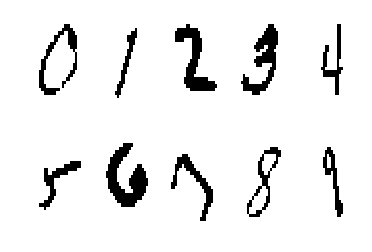

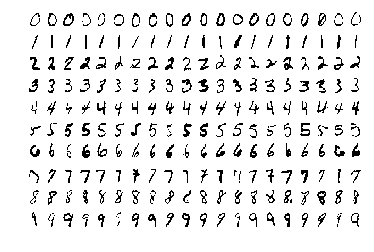

In [0]:
# 2 column x 5 row matrix
fig, ax = plt.subplots(nrows = 2, ncols = 5)

for row in range(2):
    for col in range(5):
        ax[row][col].axis("off")
        ax[row][col].imshow(
            X = np.reshape(bisected_train_data[digit_indices[(row * 5) + col][0]], (28, 28)),
            aspect = "auto",
            cmap = plt.get_cmap("Greys")
        )
plt.show()

# 20 column x 10 row matrix
fig, ax = plt.subplots(nrows = 10, ncols = IMAGES_PER_DIGIT)

for digit_idx in range(10):
    for sample_idx in range(IMAGES_PER_DIGIT):
        ax[digit_idx][sample_idx].axis("off")
        ax[digit_idx][sample_idx].imshow(
            X = np.reshape(bisected_train_data[digit_indices[digit_idx][sample_idx]], (28, 28)),
            aspect = "auto",
            cmap = plt.get_cmap("Greys")
        )
plt.show()

### Rendering Generated Images

For visual comparison with the binarized training data, generate images using the model's predicted values, and render the matrices accordingly.

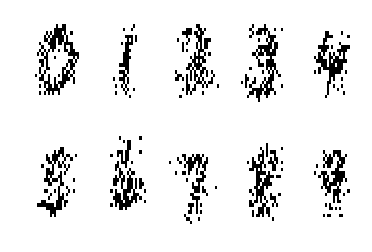

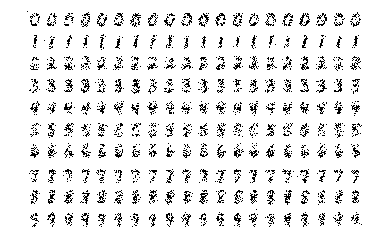

In [0]:
generated_image = np.empty(784)

# 2 column x 5 row matrix
fig, ax = plt.subplots(nrows = 2, ncols = 5)

for row in range(2):
    for col in range(5):
    
        for i in range(784):
            generated_image[i] = np.random.choice(
                2, # 0 or 1
                p = [
                    1.0 - pixel_probabilities[(row * 5) + col][i], 
                    pixel_probabilities[(row * 5) + col][i]
                ]
            )

        ax[row][col].axis("off")
        ax[row][col].imshow(
            X = np.reshape(generated_image, (28, 28)),
            aspect = "auto",
            cmap = plt.get_cmap("Greys")
        )
        
plt.show()

# 20 column x 10 row matrix
fig, ax = plt.subplots(nrows = 10, ncols = IMAGES_PER_DIGIT)

for digit_idx in range(10):
    for sample_idx in range(IMAGES_PER_DIGIT):

        for i in range(784):
            generated_image[i] = np.random.choice(
                2, # 0 or 1
                p = [
                    1.0 - pixel_probabilities[digit_idx][i], 
                    pixel_probabilities[digit_idx][i]
                ]
            )

        ax[digit_idx][sample_idx].axis("off")
        ax[digit_idx][sample_idx].imshow(
            X = np.reshape(generated_image, (28, 28)),
            aspect = "auto",
            cmap = plt.get_cmap("Greys")
        )

plt.show()

### Answer

Generated digits certainly respect the outer perimeters of each digit's shape; e.g. zeros look like zeros, digits have an appropriate (and anticipated) amount of whitespace surrounding them.

However, generated digits differ from the training digits in that the are more visually sparse.  This is anticipated, as rendering a training digit will always be using pixel data *associated with that specific training digit*.  In contrast, a generated digit will be choosing pixel data *based upon the probability for the pixel value calculated from the entire training set*.

## Question 11

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [0]:
def get_bucket_idx(buckets, p):
    '''
    Identify the index of the bucket in which to bin the predicted probability.
    '''
    
    assert (type(buckets) == list), "buckets must be a list"
    assert (len(buckets) > 0), "buckets must contain at least one value"
    assert (type(p) == np.float64), "p must be of type numpy.float64"
    
    for i in range(len(buckets)):
        if (p <= buckets[i]):
            return i
    return len(buckets) - 1

def P11(buckets, correct, total):
    
    # Create and train the Bernoulli naive Bayes classifier.  Predict values using the test data,
    # and identify the associated posterior probabilities
    classifier = BernoulliNB(alpha = 0.0)
    classifier.fit(X = train_data, y = train_labels)
    predicted_values = classifier.predict(X = dev_data)
    pp_matrix = classifier.predict_proba(X = dev_data)
    
    # Iterate through predicted test values, and accumulate the total number of data elements 
    # whose maximum predicted probabilities fall beneath the (cumulative) prediction buckets, as
    # well as whether the classifier identified each data element correctly.
    for i in range(dev_data.shape[0]):
        
        # Retrieve probabilities for the current digit in the test data
        pp_array = pp_matrix[i]
        pp_max_idx = np.argmax(pp_array)
        bucket_idx = get_bucket_idx(buckets, pp_array[pp_max_idx])
        
        
        for j in range(bucket_idx, len(buckets)):
            total[j] += 1.0
        
        if (int(dev_labels[i]) == int(predicted_values[i])):
            for j in range(bucket_idx, len(buckets)):
                correct[j] += 1.0

buckets = [0.5, 0.6, 0.7, 0.8, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

P11(buckets, correct, total)

for i in range(len(buckets)):
    
    accuracy = correct[i] / total[i] if total[i] > 0 else 0.0
    print('p(pred) <= %.13f    total = %4d    correct = %3d    accuracy = %.3f' %(buckets[i], total[i], correct[i], accuracy))


p(pred) <= 0.5000000000000    total =    0    correct =   0    accuracy = 0.000
p(pred) <= 0.6000000000000    total =    7    correct =   2    accuracy = 0.286
p(pred) <= 0.7000000000000    total =   14    correct =   4    accuracy = 0.286
p(pred) <= 0.8000000000000    total =   27    correct =   8    accuracy = 0.296
p(pred) <= 0.9000000000000    total =   34    correct =  14    accuracy = 0.412
p(pred) <= 0.9990000000000    total =   98    correct =  46    accuracy = 0.469
p(pred) <= 0.9999900000000    total =  155    correct =  79    accuracy = 0.510
p(pred) <= 0.9999999000000    total =  198    correct = 105    accuracy = 0.530
p(pred) <= 0.9999999990000    total =  248    correct = 138    accuracy = 0.556
p(pred) <= 0.9999999999900    total =  298    correct = 177    accuracy = 0.594
p(pred) <= 0.9999999999999    total =  363    correct = 225    accuracy = 0.620
p(pred) <= 1.0000000000000    total = 1000    correct = 830    accuracy = 0.830


### Answer

It appears that the naive Bayes classifier performs the worst when its predicted probability is the lowest.  For example,

* When the predicted probability is less than or equal to 0.6, the observed accuracy among the test data is 0.286.
* When the predicted probability is less than or equal to 1.0 (representing all of the tested data), the observed accuracy among the test data is 0.830.

The classifier appears to be particularly confident, but its accuracy doesn't exhibit this confidence.  For example, the greatest number of predicted probabilities in the test data was observed between probability values of 0.9999999999999 and 1.0; 637 of the test images had predicted probabilities in this range.  Still, accuracy remained at 0.830 over the entire test data set.

## Question 12

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [0]:
#def P12():

### STUDENT START ###


### STUDENT END ###

#P12()